# AutoEncoders can also be used for turning pictures from light microscope into pictures from electronic microscope (na ulazu su slike sa svetlosnog mikroskopa, dok na izlazu trazimo slike sa elektronskog)
# Takodje, za transformaciju crno-belih slika u slike sa bojom -> tada crno-bele slike prebacujemo u Lab space (koliko je svetla - tako ce boja biti rasporedjena)

# Imports

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from keras.preprocessing.image import img_to_array
from tqdm import tqdm                       # visualize things happening inside for loop

# Read Dataset

In [6]:
# x is noisy data and y is clean data
SIZE = 104

# before running, delete .DS_Store file

uninfected_cells=[]
path1 = './datasets/Malaria_Cells_Images/Uninfected'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i, cv2.COLOR_BGR2RGB)           # read .png image as numpy array
    img=cv2.resize(img,(SIZE, SIZE))                            # make smaller resolution
    uninfected_cells.append(img_to_array(img))
    
uninfected_train = np.reshape(uninfected_cells, (len(uninfected_cells), SIZE, SIZE, 3))      # add 4th dimension
uninfected_train = uninfected_train.astype('float32') / 255.

infected_cells=[]
path1 = './datasets/Malaria_Cells_Images/Parasitized'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i, cv2.COLOR_BGR2RGB)           # read .png image as numpy array
    img=cv2.resize(img,(SIZE, SIZE))                            # make smaller resolution
    infected_cells.append(img_to_array(img))
    
infected_train = np.reshape(infected_cells, (len(infected_cells), SIZE, SIZE, 3))      # add 4th dimension
infected_train = infected_train.astype('float32') / 255.


100%|██████████| 13779/13779 [00:07<00:00, 1750.81it/s]


# Plot dataset examples

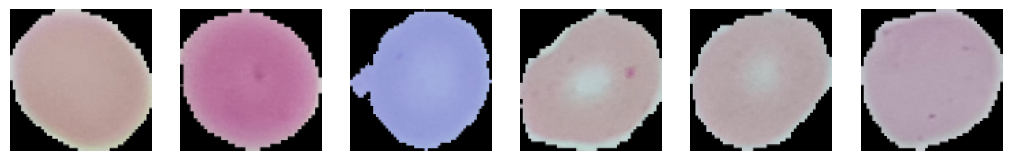

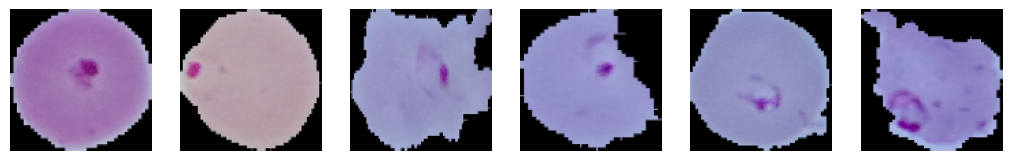

In [7]:
# Prikazivanje neinficiranih ćelija (RGB)
plt.figure(figsize=(15, 2))
for i in range(1, 7):
    ax = plt.subplot(1, 7, i)
    plt.imshow(uninfected_train[i].reshape(SIZE, SIZE, 3))  # RGB slike imaju 3 kanala
    plt.axis("off")  
plt.show()

# Prikazivanje inficiranih ćelija (RGB)
plt.figure(figsize=(15, 2))
for i in range(1, 7):
    ax = plt.subplot(1, 7, i)
    plt.imshow(infected_train[i].reshape(SIZE, SIZE, 3))  # RGB format
    plt.axis("off")  
plt.show()


# Creating the Architecture of an Autoencoder

In [8]:

model = Sequential()
# Encoder deo
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# Decoder deo
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

model.summary()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(uninfected_train, uninfected_train, 
                                                    test_size = 0.20, random_state = 0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 104, 104, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 104, 104, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 104, 104, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.fit(x_train, y_train, epochs=5, batch_size=8, shuffle=True, verbose = 1,
          validation_split = 0.1)

print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(x_test), np.array(y_test))[1]*100))

Epoch 1/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 2/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 7.6637e-04 - val_mse: 7.6637e-04
Epoch 4/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 6.8582e-04 - mse: 6.8582e-04 - val_loss: 5.3283e-04 - val_mse: 5.3283e-04
Epoch 5/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 5.3318e-04 - mse: 5.3318e-04 - val_loss: 4.5729e-04 - val_mse: 4.5729e-04
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.5742e-04 - mse: 4.5742e-04
Test_Accuracy: 0.05%


# Plot how well it reconstructs uninfected cells.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


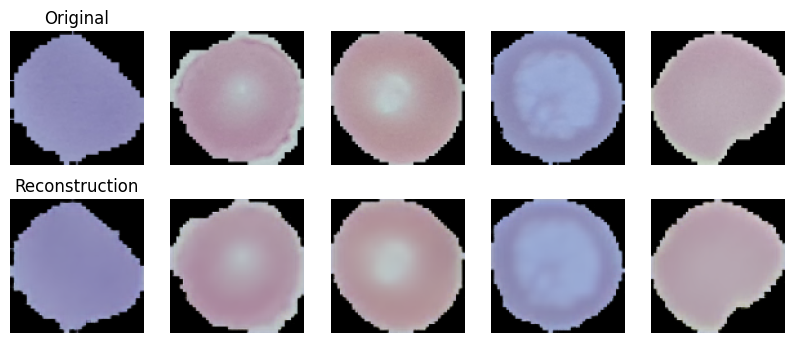

In [17]:
import random

# nekoliko slika iz test skupa
num_images = 5
indices = random.sample(range(len(x_test)), num_images)
test_images = x_test[indices]

# Rekonstruiši slike pomoću modela
reconstructed_images = model.predict(test_images)

# Prikaži originalne i rekonstruisane slike
plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Original
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(test_images[i].reshape(SIZE, SIZE, 3))  # Prikaz u RGB formatu
    plt.axis("off")
    if i == 0:
        ax.set_title("Original")

    # Rekonstruisana slika
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed_images[i].reshape(SIZE, SIZE, 3))  # Prikaz u RGB formatu
    plt.axis("off")
    if i == 0:
        ax.set_title("Reconstruction")

plt.show()


# Show how well model performs when classifying infected and uninfected cells.

In [ ]:
# it should group MSE around one value for uninfected cells and by another for infected one
pred = model.predict(x_test)

# Poravnanje u 2D niz
pred_flat = pred.reshape(len(pred), -1)
x_test_flat = x_test.reshape(len(x_test), -1)

# srednja kvadratna greska (MSE)
score1 = np.sqrt(metrics.mean_squared_error(pred_flat, x_test_flat))
print("Reconstruction error for uninfected cells (RMSE):", score1)


# Predikcija za inficirane ćelije
pred_infected = model.predict(infected_train)

# Poravnanje u 2D niz
pred_infected_flat = pred_infected.reshape(len(pred_infected), -1)
infected_flat = infected_train.reshape(len(infected_train), -1)

# Srednja kvadratna greška (MSE)
score2 = np.sqrt(metrics.mean_squared_error(pred_infected_flat, infected_flat))
print("Reconstruction error for infected cells (RMSE):", score2)
print("For infected cells it will show higher RMSE")


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Reconstruction error for uninfected cells (RMSE): 0.021381478560362613
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step
Reconstruction error for infected cells (RMSE): 0.021421240162998605
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
Reconstruction error for infected cells (RMSE): 0.02514290552689913
For infected cells it will show higher RMSE


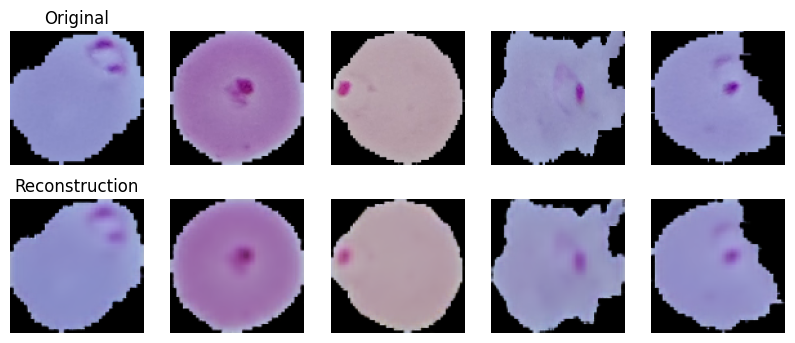

In [19]:
# Prikaži originalne i rekonstruisane slike za inficirane ćelije
plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Original
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(infected_train[i].reshape(SIZE, SIZE, 3))  # Prikaz RGB
    plt.axis("off")
    if i == 0:
        ax.set_title("Original")

    # Rekonstruisana slika
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(pred_infected[i].reshape(SIZE, SIZE, 3))  # Prikaz RGB
    plt.axis("off")
    if i == 0:
        ax.set_title("Reconstruction")

plt.show()


431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step


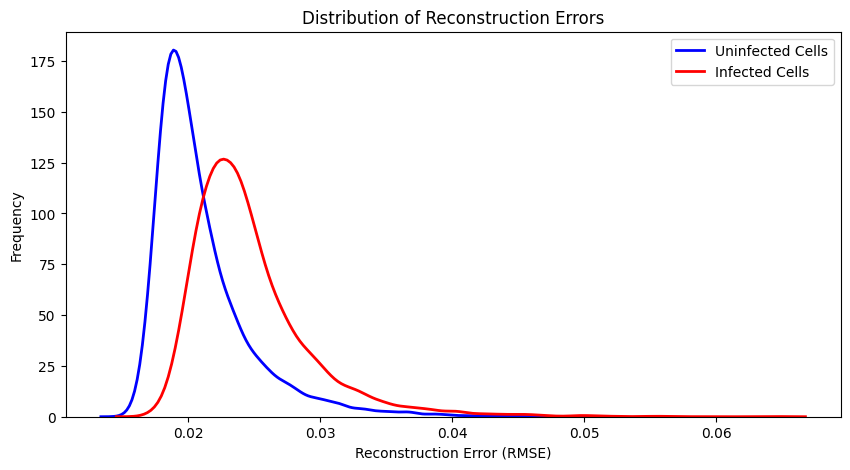

In [20]:
import seaborn as sns

# Izračunaj RMSE za sve neinficirane i inficirane slike
uninfected_errors = np.sqrt(np.mean((uninfected_train - model.predict(uninfected_train))**2, axis=(1,2,3)))
infected_errors = np.sqrt(np.mean((infected_train - model.predict(infected_train))**2, axis=(1,2,3)))

# Crtanje histograma
plt.figure(figsize=(10, 5))
sns.kdeplot(uninfected_errors, color='blue', linewidth=2, label="Uninfected Cells")
sns.kdeplot(infected_errors, color='red', linewidth=2, label="Infected Cells")

plt.xlabel("Reconstruction Error (RMSE)")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.show()
